# Analyze Sparse Grid for Supporting Information

In [3]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

import oaat_library.utils as utils
import oaat_library.processing as proc
import oaat_library.plotting as plotting

In [4]:
# Setup PBSCluster
cluster = PBSCluster(
    cores=1,                                                   # The number of cores you want
    memory='25GB',                                             # Amount of memory
    processes=1,                                               # How many processes
    queue='casper',                                            # The type of queue to utilize
    local_directory='/glade/work/afoster',                     # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB',                 # Specify resources
    log_directory='/glade/derecho/scratch/afoster/dask_logs',  # log directory
    account='P08010000',                                       # Input your project ID here
    walltime='04:00:00',                                       # Amount of wall time
    interface='ext')

In [5]:
cluster.scale(30)
dask.config.set({
    'distributed.dashboard.link': 'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
})
client = Client(cluster)
client

<Client: 'tcp://128.117.208.174:36773' processes=0 threads=0, memory=0 B>

In [67]:
# client.shutdown()

## Set Up

First specify history variables and variables to investigate

In [12]:
# top directory (i.e. path to this repository)
top_dir = '/glade/work/afoster/oaat_fates_clm'

# sparse grid clustering file
grid_dir = '/glade/work/afoster/FATES_calibration/surfdata'
grid_file = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
sparse_grid = xr.open_dataset(os.path.join(grid_dir, grid_file))

# sparse grid whittaker biomes
whittaker_ds = xr.open_dataset('/glade/work/afoster/FATES_calibration/observations/whittaker/whitkey.nc')

# fetch the sparsegrid landarea - needed for unit conversion
land_area_file = '/glade/work/afoster/FATES_calibration/CLM5PPE/postp/sparsegrid_landarea.nc'
land_area = xr.open_dataset(land_area_file).landarea

# land area and land fraction for mapping
land_frac_file = os.path.join(data_dir, 'surface_data',
                            "ctsm60SP_bigleaf_fullgrid.clm2.h0.0001-02-01-00000.nc")
target_grid = proc.create_target_grid(land_frac_file, 'FSR')


# variable information (units, conversion factors, long names, etc.)
var_config = os.path.join(top_dir, 'configs', 'variable_conversion.yml')
var_dict = utils.get_config_file(var_config)

# directory to place figures
fig_dir = os.path.join(top_dir, 'figures', 'supplementary_figs')

In [13]:
# variables

fates_vars = ['FATES_FRACTION', 'FATES_GPP', 'FATES_LAI', 'QVEGE',
              'QSOIL', 'QVEGT', 'EFLX_LH_TOT', 'FSH', 'FSR', 'FSDS', 'FSA',
              'FIRE', 'FLDS', 'FCTR', 'FCEV', 'FGEV', 'BTRANMN',
              'FGR', 'SOILWATER_10CM', 'TWS', 'QRUNOFF', 'SNOWDP',
              'TV', 'TG', 'TSA', 'RH2M', 'SNOW', 'RAIN', 'FGR12',
              'TREFMXAV', 'TREFMNAV']

clm_vars = ['FPSN', 'TLAI', 'QVEGE', 'QVEGT', 'QSOIL', 'EFLX_LH_TOT', 'FSH',
            'FSR', 'FSDS', 'FSA', 'FIRE', 'FLDS', 'FCTR', 'FCEV',
            'FGEV', 'BTRANMN', 'FGR', 'SOILWATER_10CM', 'TWS',
            'QRUNOFF', 'SNOWDP', 'TV', 'TG', 'TSA', 'RH2M', 'SNOW', 'RAIN',
            'FGR12', 'TREFMXAV', 'TREFMNAV']

out_vars = ['GPP', 'LAI', 'EFLX_LH_TOT', 'FSH', 'EF', 'SOILWATER_10CM', 'ASA',
            'FSDS', 'FSR', 'FSA', 'FIRE', 'RLNS', 'RN', 'BTRANMN', 'TV', 'Temp',
            'RH2M', 'Precip', 'QRUNOFF', 'QSOIL', 'QVEGT', 'QVEGE']

### Files Needed

## Read in Datasets

In [29]:
# FATES sparse grid run
sparse_fates_dir = '/glade/derecho/scratch/afoster/archive/ctsm60SP_fates_sparse_vai_default_latest/lnd/hist'
sparse_fates_ds = proc.post_process_ds(sparse_fates_dir, fates_vars,
                                      years=[2000, 2014],
                                      run_dict={'filter_years': [2045, 2059]},
                                      whittaker_ds=whittaker_ds)

In [30]:
# FATES global run
global_fates_dir = '/glade/derecho/scratch/afoster/archive/ctsm60SP_fates_full/lnd/hist'
global_fates_ds = proc.post_process_ds(global_fates_dir, fates_vars,
                                      years=[2000, 2014],
                                      run_dict={'filter_years': [2045, 2059], 'sparse': False},
                                      whittaker_ds=whittaker_ds)

In [31]:
# CLM sparse grid run
sparse_clm_dir = '/glade/derecho/scratch/afoster/archive/ctsm60SP_bigleaf_sparse_update/lnd/hist'
sparse_clm_ds = proc.post_process_ds(sparse_clm_dir, clm_vars,
                                      years=[2000, 2014],
                                      run_dict={'filter_years': [2045, 2059], 'fates': False},
                                      whittaker_ds=whittaker_ds)

In [32]:
# CLM sparse grid run
global_clm_dir = '/glade/derecho/scratch/afoster/archive/ctsm60SP_bigleaf_full/lnd/hist'
global_clm_ds = proc.post_process_ds(global_clm_dir, clm_vars,
                                      years=[2000, 2014],
                                      run_dict={'filter_years': [2045, 2059], 'fates': False,
                                               'sparse': False},
                                      whittaker_ds=whittaker_ds)

## Post-Process Datasets


### Temporal Averaging
First calculate annual and monthly means

In [34]:
# annual means
fates_ann_means_sparse = proc.apply_to_vars(sparse_fates_ds, out_vars, func=proc.calculate_annual_mean, add_sparse=True,
                                         conversion_factor={var: var_dict[var]["time_conversion_factor"] for var in out_vars},
                                         new_units={var: var_dict[var]["annual_units"] for var in out_vars})

fates_ann_means_glob = proc.apply_to_vars(global_fates_ds, out_vars,
                                         func=proc.calculate_annual_mean,
                                         add_sparse=False,
                                         conversion_factor={var: var_dict[var]["time_conversion_factor"] for var in out_vars},
                                         new_units={var: var_dict[var]["annual_units"] for var in out_vars})

clm_ann_means_sparse = proc.apply_to_vars(sparse_clm_ds, out_vars, func=proc.calculate_annual_mean, add_sparse=True,
                                         conversion_factor={var: var_dict[var]["time_conversion_factor"] for var in out_vars},
                                         new_units={var: var_dict[var]["annual_units"] for var in out_vars})

clm_ann_means_glob = proc.apply_to_vars(global_clm_ds, out_vars,
                                         func=proc.calculate_annual_mean,
                                         add_sparse=False,
                                         conversion_factor={var: var_dict[var]["time_conversion_factor"] for var in out_vars},
                                         new_units={var: var_dict[var]["annual_units"] for var in out_vars})

### Remap Sparse Grid

Remap the annual and monthly sparse means to a global grid

In [42]:
# maps from the annual means
fates_sparse_glob = proc.get_sparse_maps(fates_ann_means_sparse.mean(dim='year'), sparse_grid,
                                     out_vars)

clm_sparse_glob = proc.get_sparse_maps(clm_ann_means_sparse.mean(dim='year'), sparse_grid,
                                     out_vars)

### Calculate Global Annual Values

Area-weighted averages

In [44]:
# sparse area means
fates_area_means_sparse = proc.get_sparse_area_means(fates_ann_means_sparse,
                                            'global', out_vars,
                                            var_dict, land_area, sparse_fates_ds.biome)

fates_area_means_global = proc.apply_to_vars(fates_ann_means_glob, out_vars,
                                            func=proc.area_mean,
                                            add_sparse=False,
                                            cf={var: var_dict[var]["area_conversion_factor"] for var in out_vars},
                                            land_area=target_grid.land_area)

clm_area_means_sparse = proc.get_sparse_area_means(clm_ann_means_sparse,
                                            'global', out_vars,
                                            var_dict, land_area, sparse_clm_ds.biome)

clm_area_means_glob = proc.apply_to_vars(clm_ann_means_glob, out_vars,
                                            func=proc.area_mean,
                                            add_sparse=False,
                                            cf={var: var_dict[var]["area_conversion_factor"] for var in out_vars},
                                            land_area=target_grid.land_area)

## How Well the Does the Sparse Grid Match Global Simulations
### Annual Maps

In [45]:
importlib.reload(plotting)

<module 'oaat_library.plotting' from '/glade/work/afoster/oaat_fates_clm/oaat_library/plotting.py'>

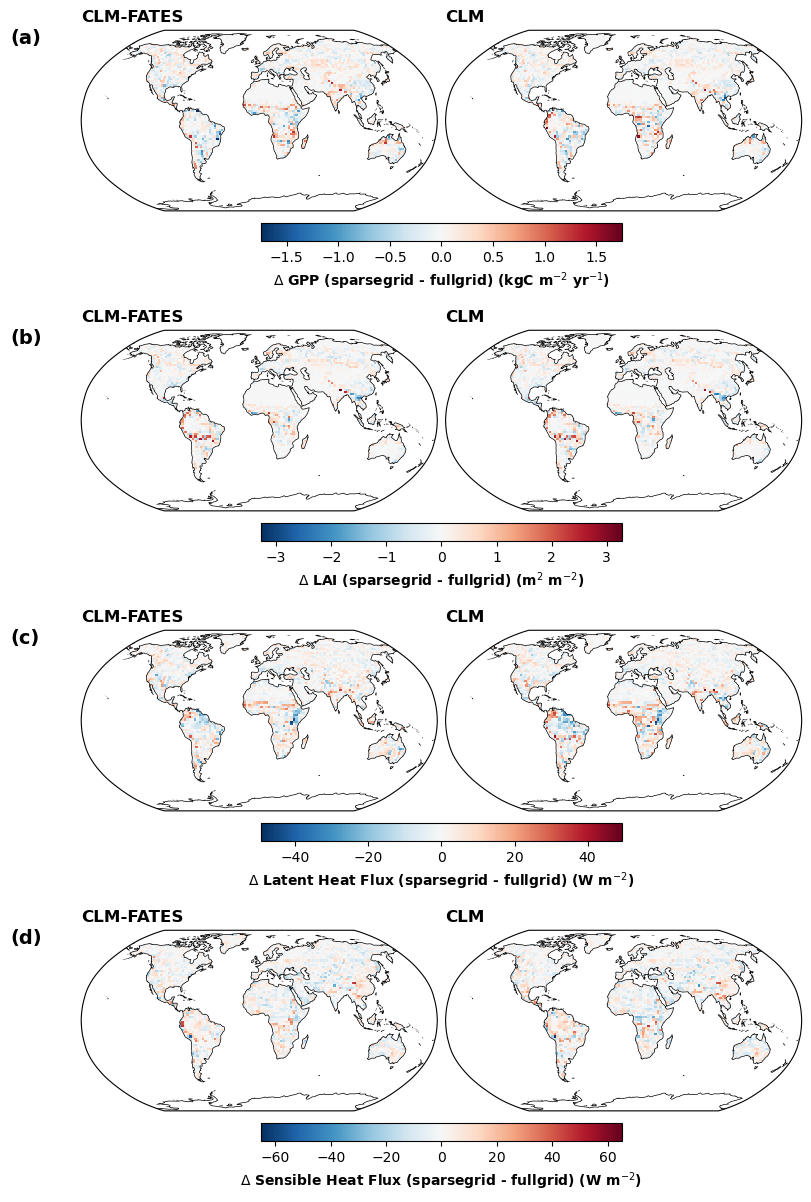

In [47]:
plotting.plot_grid_maps(out_vars[:4], fates_sparse_glob, fates_ann_means_glob,
               clm_sparse_glob, clm_ann_means_glob, target_grid, var_dict)
plt.savefig(os.path.join(fig_dir, 'sparsegrid_full_comp1.png'), bbox_inches='tight')

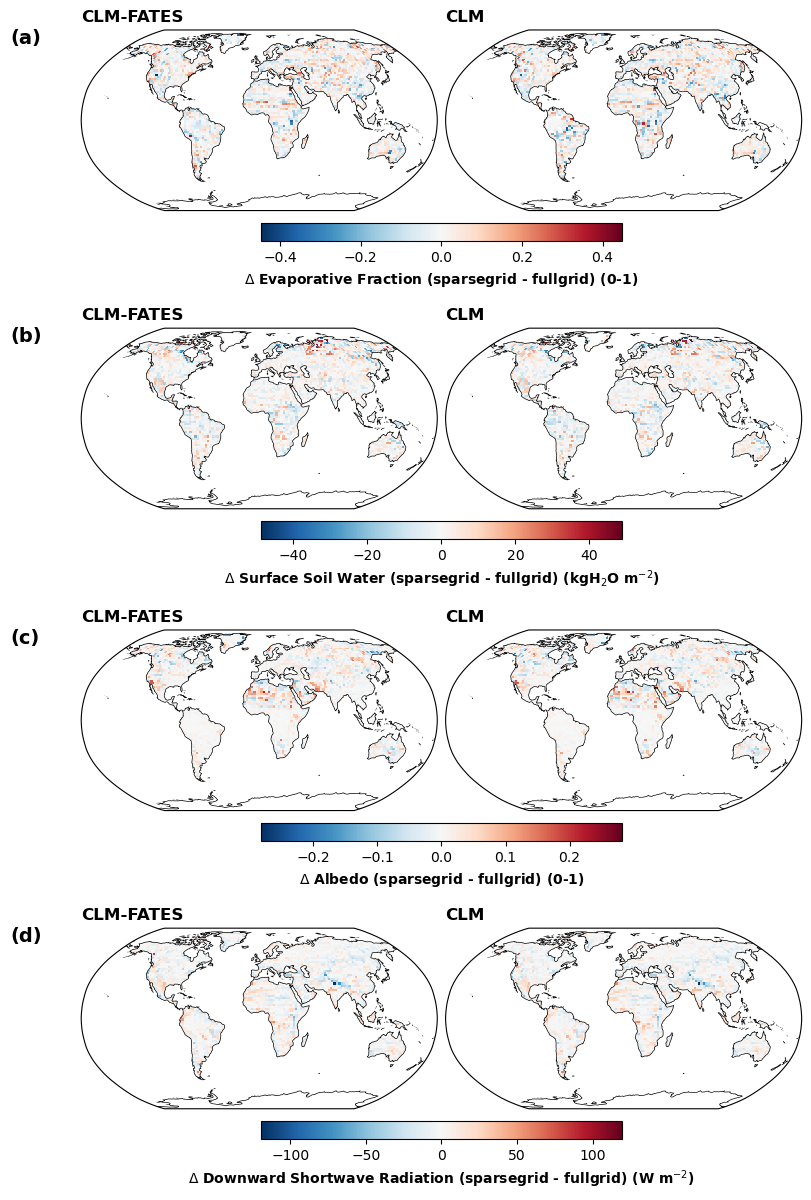

In [48]:
plotting.plot_grid_maps(out_vars[4:8], fates_sparse_glob, fates_ann_means_glob,
               clm_sparse_glob, clm_ann_means_glob, target_grid, var_dict)
plt.savefig(os.path.join(fig_dir, 'sparsegrid_full_comp2.png'), bbox_inches='tight')

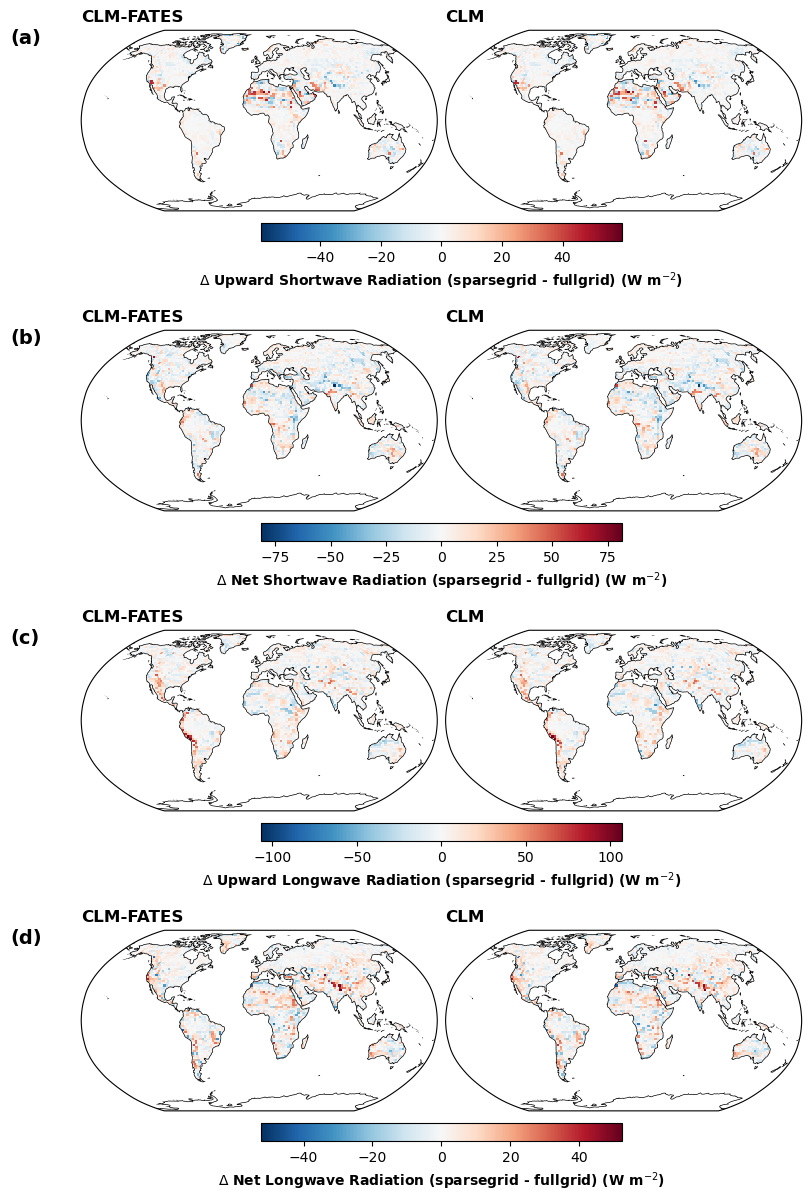

In [49]:
plotting.plot_grid_maps(out_vars[8:12], fates_sparse_glob, fates_ann_means_glob,
               clm_sparse_glob, clm_ann_means_glob, target_grid, var_dict)
plt.savefig(os.path.join(fig_dir, 'sparsegrid_full_comp3.png'), bbox_inches='tight')

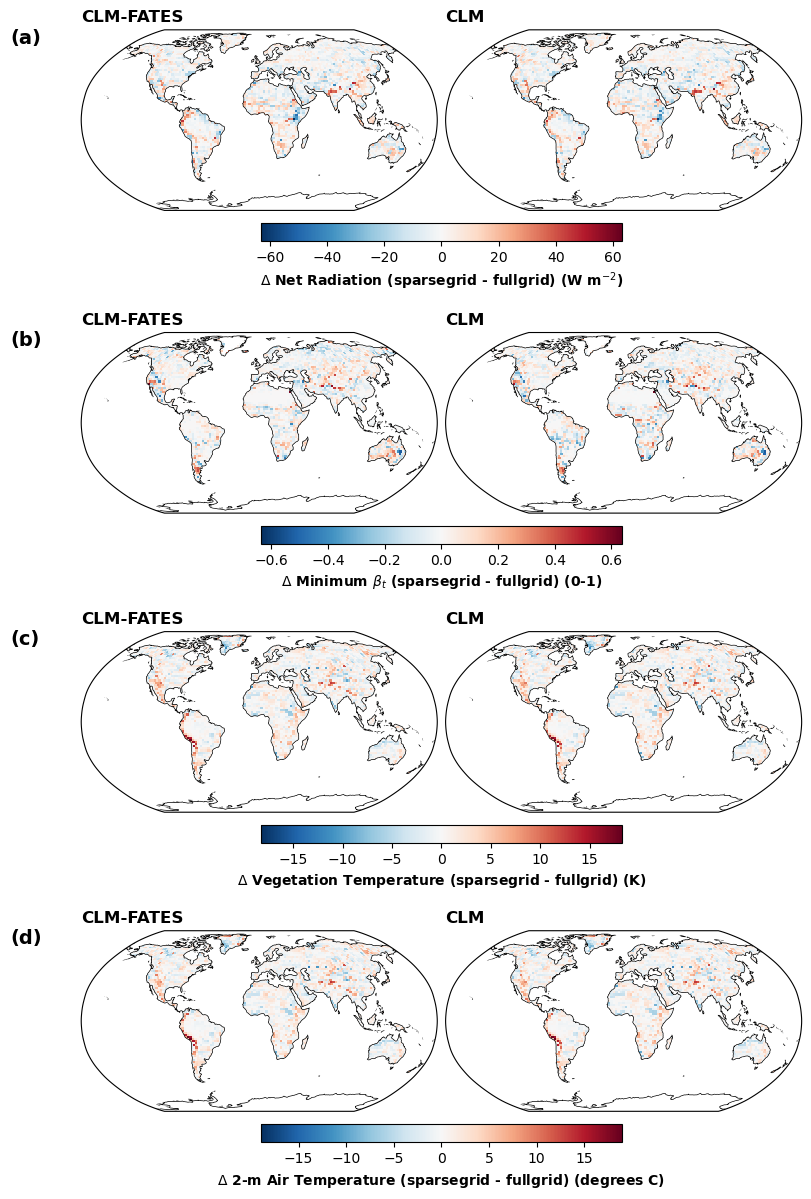

In [50]:
plotting.plot_grid_maps(out_vars[12:16], fates_sparse_glob, fates_ann_means_glob,
               clm_sparse_glob, clm_ann_means_glob, target_grid, var_dict)
plt.savefig(os.path.join(fig_dir, 'sparsegrid_full_comp4.png'), bbox_inches='tight')

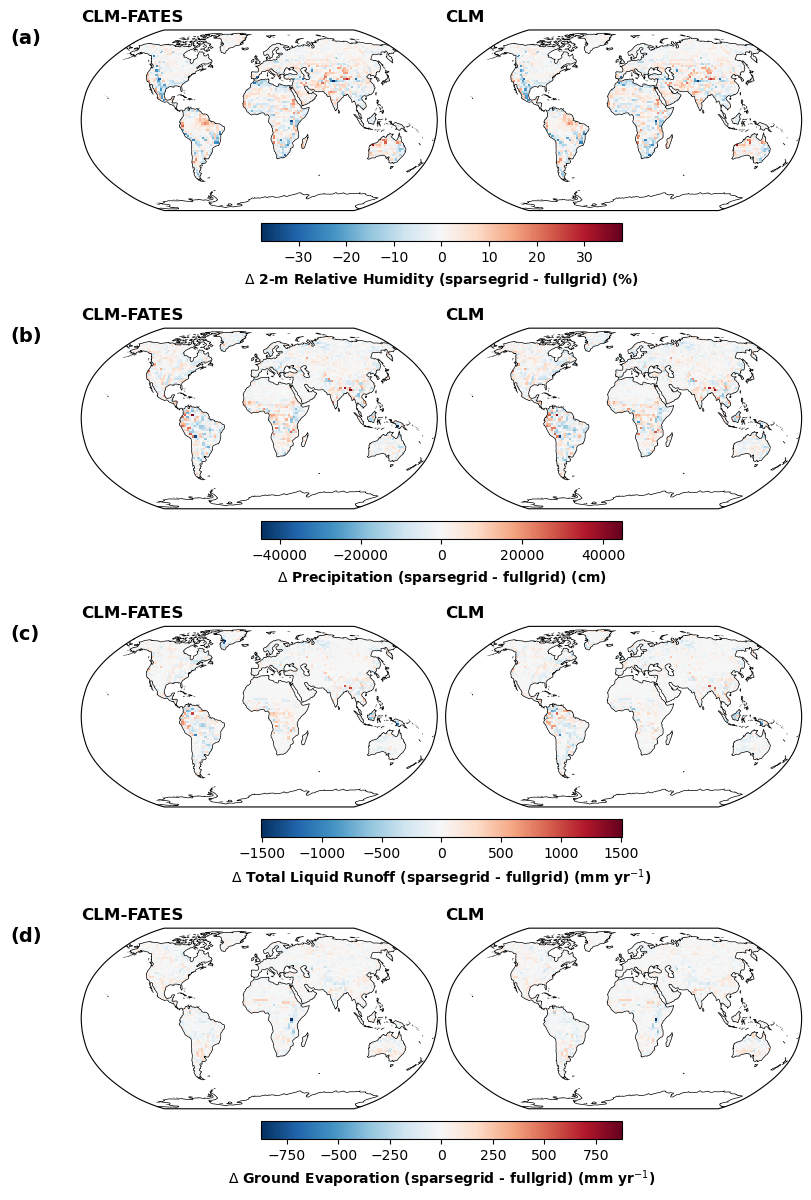

In [51]:
plotting.plot_grid_maps(out_vars[16:20], fates_sparse_glob, fates_ann_means_glob,
               clm_sparse_glob, clm_ann_means_glob, target_grid, var_dict)
plt.savefig(os.path.join(fig_dir, 'sparsegrid_full_comp5.png'), bbox_inches='tight')

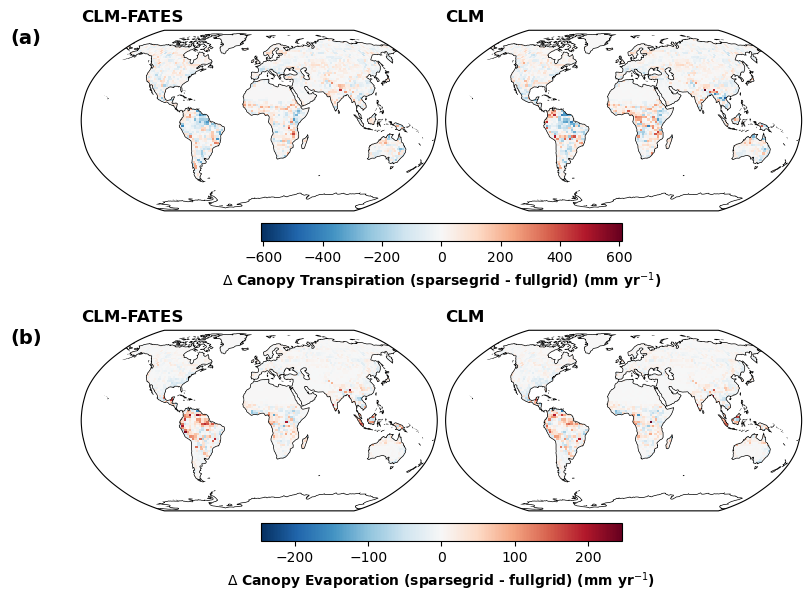

In [52]:
plotting.plot_grid_maps(out_vars[20:24], fates_sparse_glob, fates_ann_means_glob,
               clm_sparse_glob, clm_ann_means_glob, target_grid, var_dict, length=6)
plt.savefig(os.path.join(fig_dir, 'sparsegrid_full_comp6.png'), bbox_inches='tight')

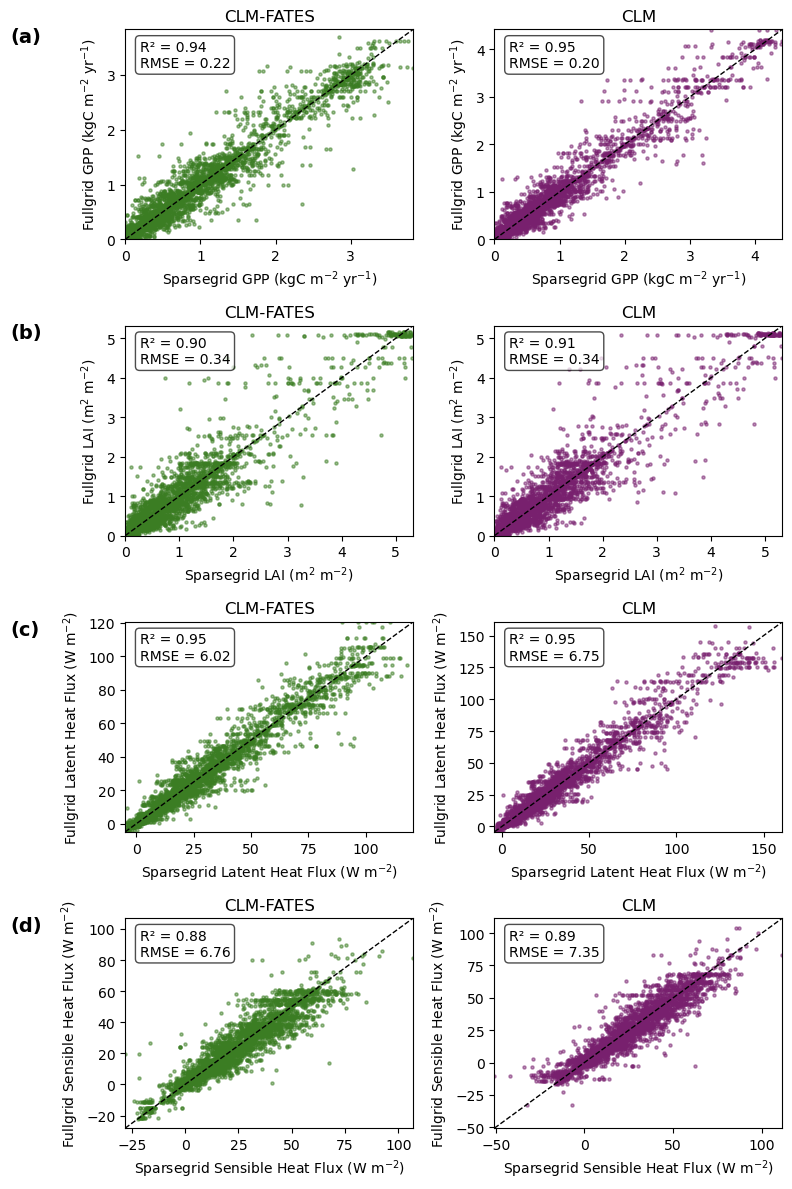

In [57]:
plotting.plot_grid(out_vars[:4], fates_ann_means_glob, fates_sparse_glob,
          clm_ann_means_glob, clm_sparse_glob, target_grid, var_dict)
plt.savefig(os.path.join(fig_dir, 'sparsegrid_scatter_comp1.png'), bbox_inches='tight')

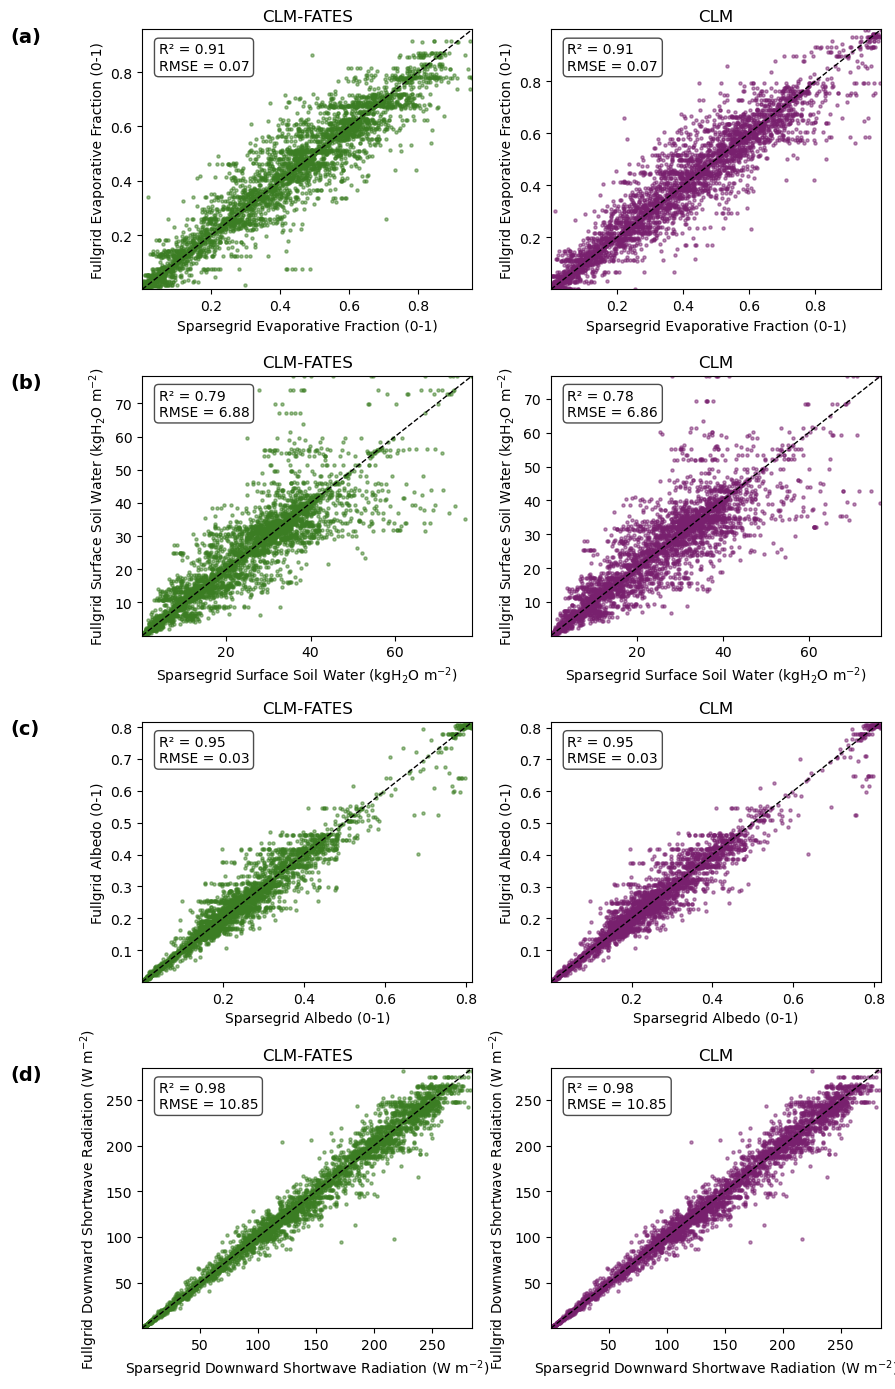

In [58]:
plotting.plot_grid(out_vars[4:8], fates_ann_means_glob, fates_sparse_glob,
          clm_ann_means_glob, clm_sparse_glob, target_grid, var_dict, length=14, width=9)
plt.savefig(os.path.join(fig_dir, 'sparsegrid_scatter_comp2.png'), bbox_inches='tight')

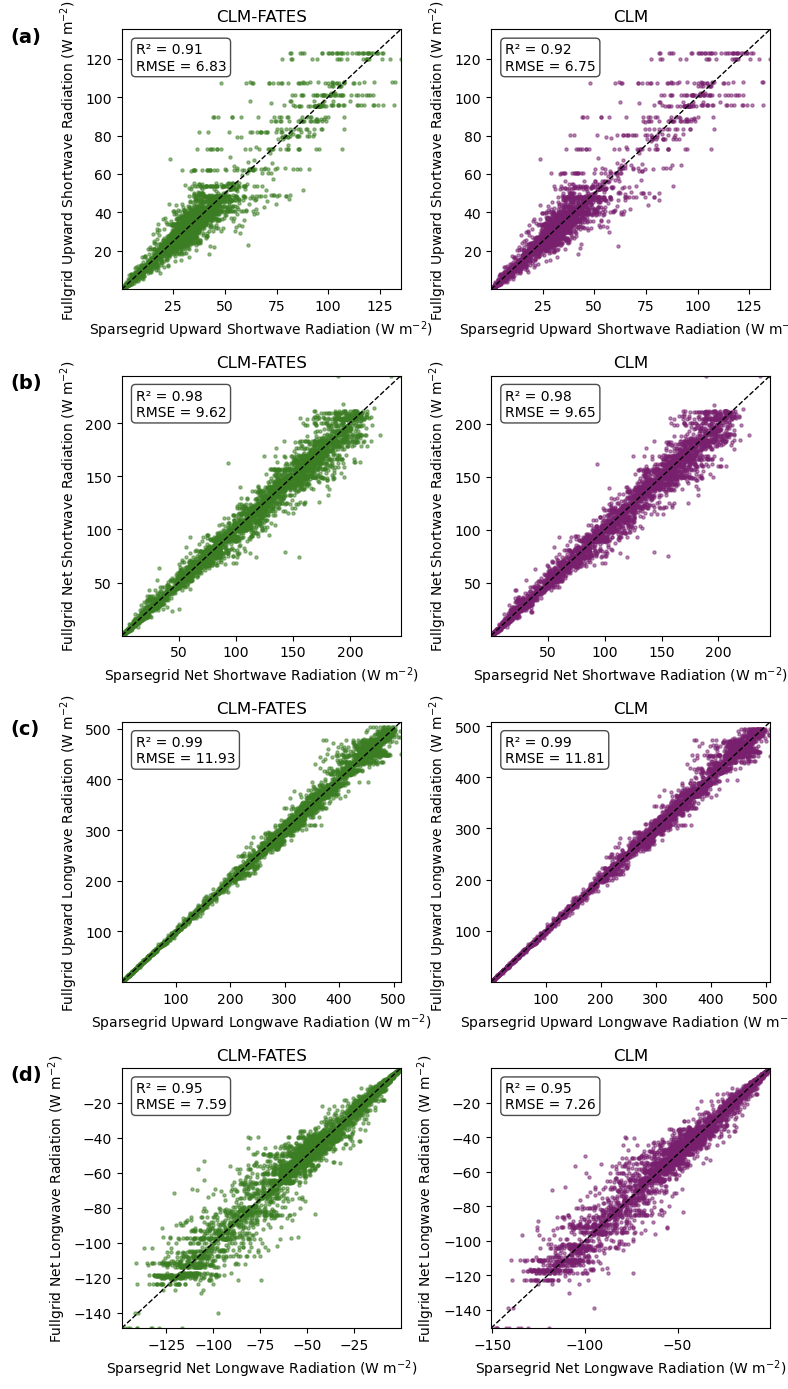

In [59]:
plotting.plot_grid(out_vars[8:12], fates_ann_means_glob, fates_sparse_glob,
          clm_ann_means_glob, clm_sparse_glob, target_grid, var_dict, length=14)
plt.savefig(os.path.join(fig_dir, 'sparsegrid_scatter_comp3.png'), bbox_inches='tight')

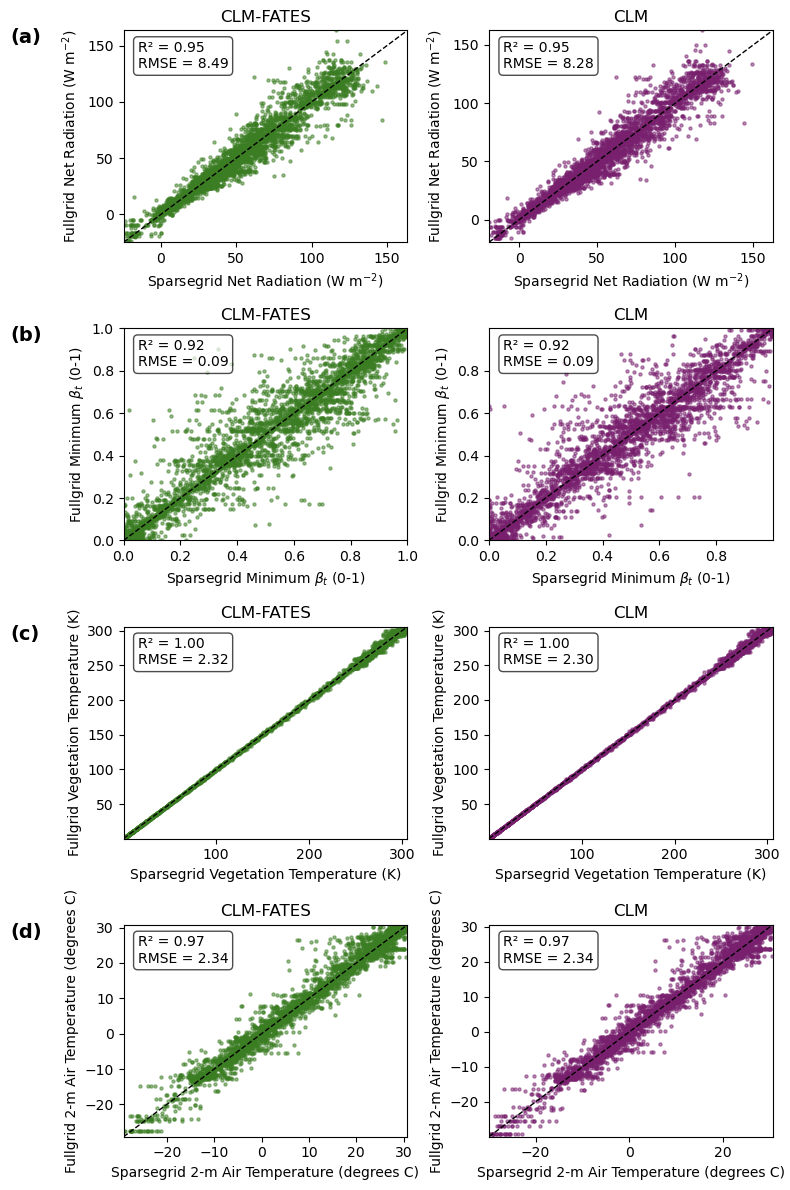

In [60]:
plotting.plot_grid(out_vars[12:16], fates_ann_means_glob, fates_sparse_glob,
          clm_ann_means_glob, clm_sparse_glob, target_grid, var_dict)
plt.savefig(os.path.join(fig_dir, 'sparsegrid_scatter_comp4.png'), bbox_inches='tight')

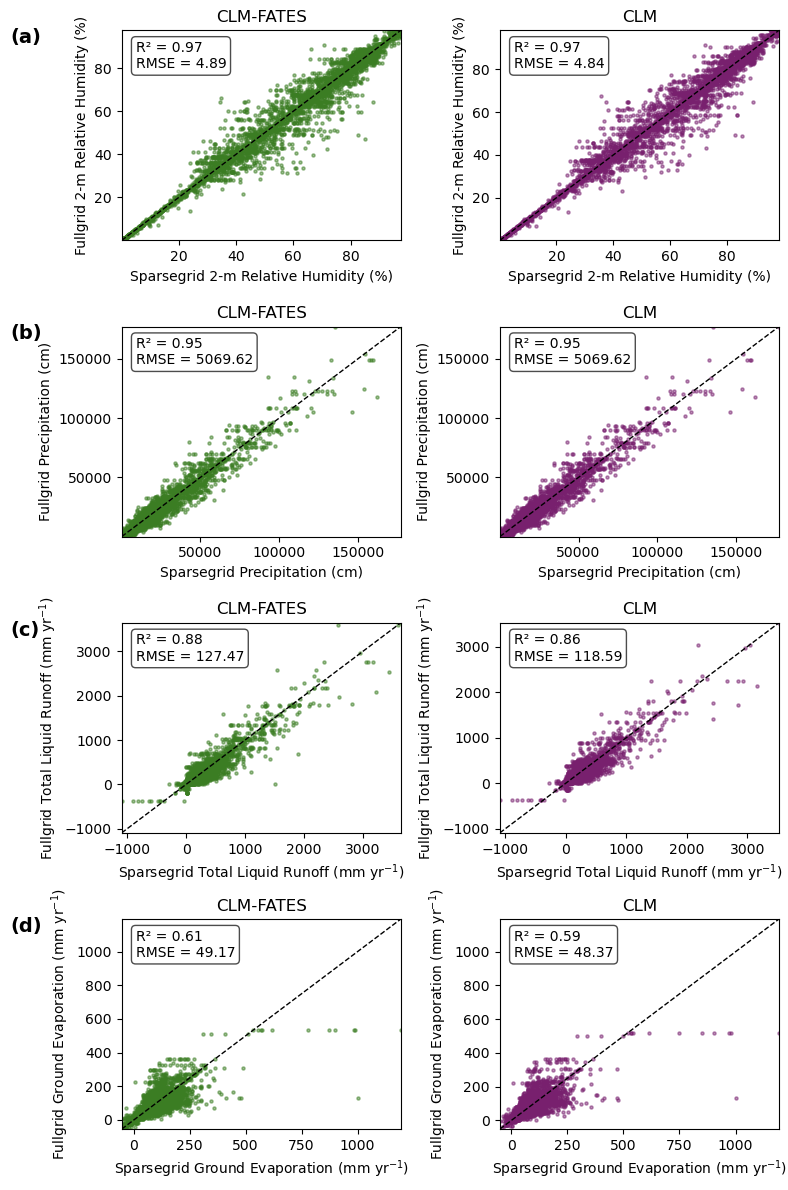

In [61]:
plotting.plot_grid(out_vars[16:20], fates_ann_means_glob, fates_sparse_glob,
          clm_ann_means_glob, clm_sparse_glob, target_grid, var_dict)
plt.savefig(os.path.join(fig_dir, 'sparsegrid_scatter_comp5.png'), bbox_inches='tight')

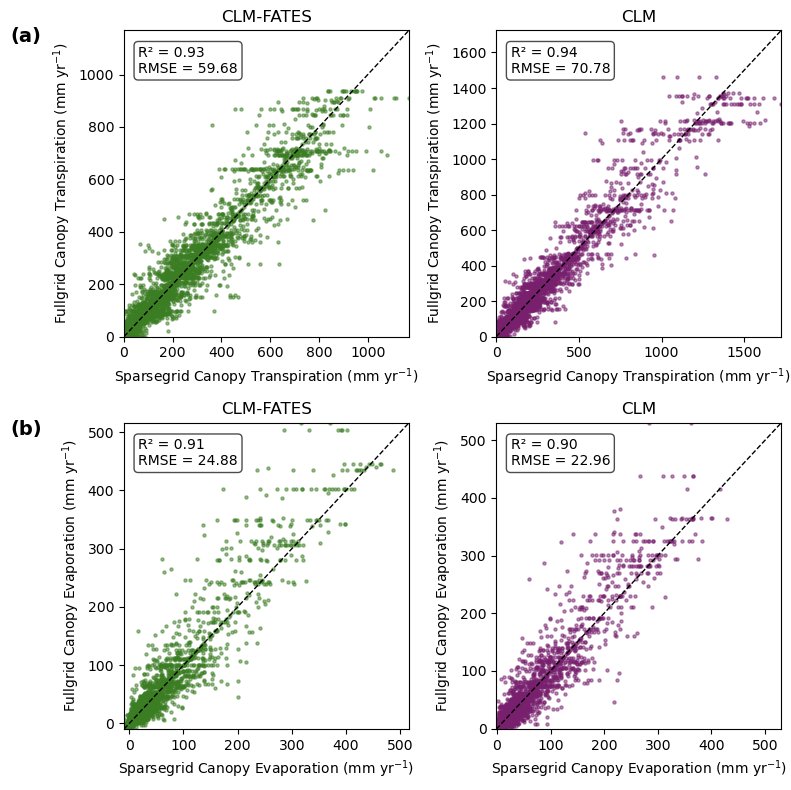

In [62]:
plotting.plot_grid(out_vars[20:24], fates_ann_means_glob, fates_sparse_glob,
          clm_ann_means_glob, clm_sparse_glob, target_grid, var_dict, length=8)
plt.savefig(os.path.join(fig_dir, 'sparsegrid_scatter_comp6.png'), bbox_inches='tight')

### Global Annual Values

In [63]:
summary_df_fates = proc.summarize_differences(fates_area_means_global.mean(dim='year'), 
                                            fates_area_means_sparse.mean(dim='year'),
                                            'Global', 'Sparse', var_dict)

In [64]:
summary_df_clm = proc.summarize_differences(clm_area_means_glob.mean(dim='year'), 
                                            clm_area_means_sparse.mean(dim='year'),
                                            'Global', 'Sparse', var_dict)

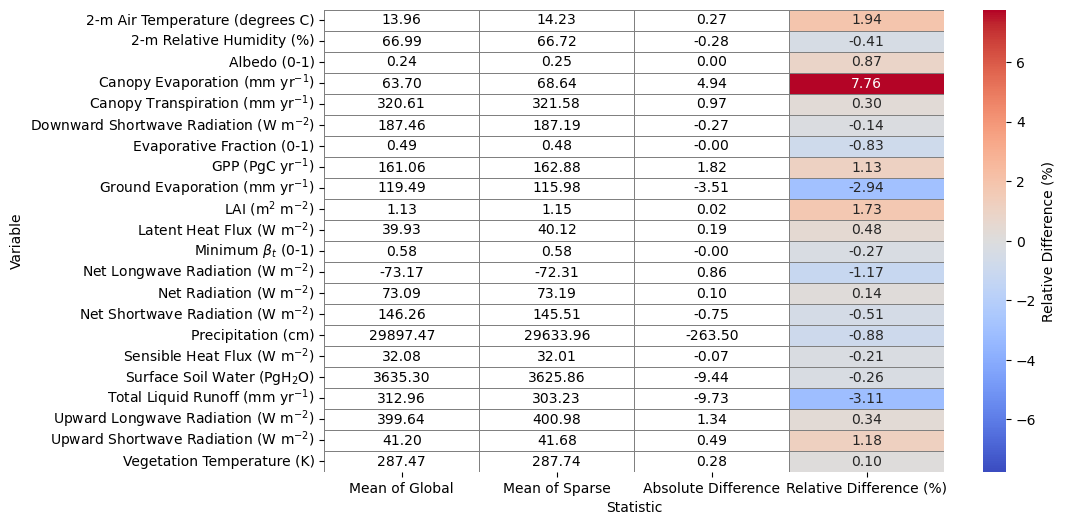

In [65]:
plotting.plot_heatmap(summary_df_fates)
plt.savefig(os.path.join(fig_dir, 'area_means_table_fates.png'), bbox_inches='tight')

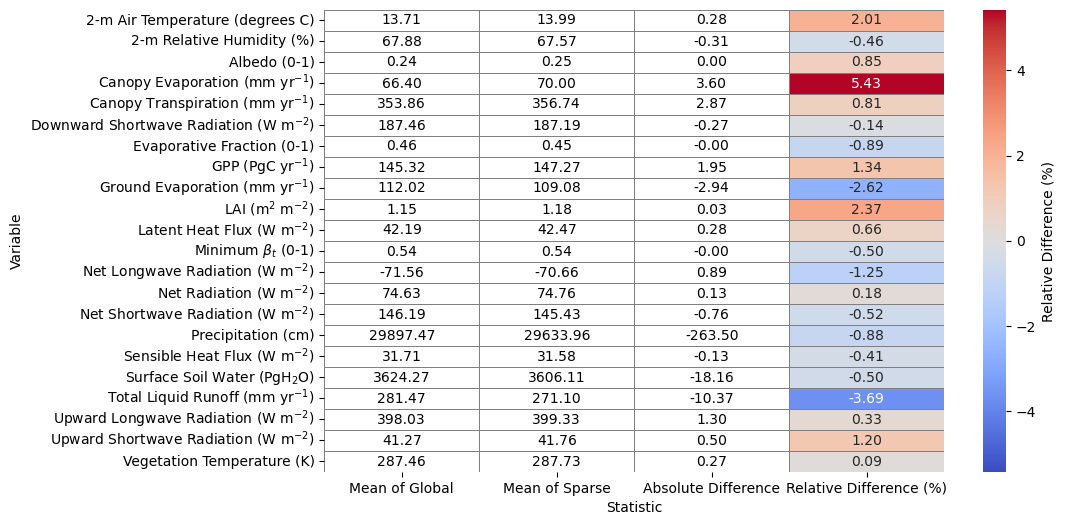

In [66]:
plotting.plot_heatmap(summary_df_clm)
plt.savefig(os.path.join(fig_dir, 'area_means_table_clm.png'), bbox_inches='tight')